# A content-based recommender system for scientific papers

# 1. Introduction

This project is part of the data science career track program at Springboard. It focuses on the development of a content-based recommender system for scientific papers using the open source database downloaded from Kaggle (i.e. arXiv). Text wrangling and preprocessing was performed using natural language took lit (nltk) libarary in Python. A recommend engine was developed based on the cosine similarities between abstracts of papers. The recommend engine is able to provide top 5 most similar papers to the paper that a user is reading. With the help of the recommender engine, we can efficiently extract relavant information from numorous scientific papers automatically, which would be of great public interest, especially in the scientific community. 

## 1.1. Problem identification and impact statement
***
[arXiv](https://arxiv.org/) is an open-access repository of electronic preprints (i.e. e-prints) of scientific papers, which covers various fields including mathematics, physics, astronomy, computer science, quantitative biology, statistics, and quantitative finance. It is a collaboratively funded, community-supported resource that is maintained and operatted by [Cornell University](https://arxiv.org/about). Since its establishment by Paul Ginsparhg in 1991, arXiv has served the public and research communities by enabling scientists worldwide to share and access research before it is formally published. As of today, arXiv has hosted over 1.7 million scholarly articles. With the exponentially increasing numbers of articles, extracting relavant information efficiently becomes a challenge. Fortunately, it is possible to make the exploration of scholarly articles faster and more accurate, with the help of recommender systems. So far, most recommender systems are available for applications in movie, news, music, and product recommendations. In contrast, relatively fewer efforts have addressed recommendation of scientific papers. 

Therefore, the Goal of this project is **to develop a recommender system that can present the users with related articles based on the abstract of the article they are reading**

> <img align='center' width='200' height='150' src="arXiv.jpeg">

## 1.2. Dataset description

The dataset is downloaded from [Kaggle](https://www.kaggle.com/Cornell-University/arxiv). Below is a description of each of the 10 attributes: 

| No. | Variable name | Description |
| --- | --- | --- | 
| 1 | id | ArXiv ID | 
| 2 | submitter | Who submitted the paper | 
| 3 | authors | Authors of the paper | 
| 4 | title | Title of the paper |
| 5 | comments | Additional info, such as number of pages and figures |
| 6 | journal-ref | Information about the journal the paper was published in |
| 7 | doi |[Digital Object Identifier](https://www.doi.org)|
| 8 | abstract | The abstract of the paper|
| 9 | categories | Categories / tags in the ArXiv system |
| 10 | versions | A version history |


## 1.3. Methdology 
A general workflow is outlined below: 
***
* Text wrangling, and preprocessing
  * Load libraries
  * Load data, select and define columns
  * Data cleaning: deal with missing values, duplicated entries
  * Text preprocessing: 
    * Remove irrelevant characters (e.g. numbers, punctuation)
    * Convert all characters into lowercase
    * Tokenization (the process of converting text into individual words - tokens)
    * Removing Stopwords (words that are too common and do not qualify for being good keywords for search)
    * Lemmatization (converting each word to its lemma word (e.g. ran, running are converted to run) to reduce words of similar roots to similar tokens)
    * Remove the words having lenth < 2 
    * Convert the list of tokens to string
    * Export the cleaned text   
* Exploratory Data Analysis (EDA)
* Recommendation engine: 
  * Convert each abstract into vectors using TF-IDF and unigram
  * Calculate similarity between all abstracts using cosine similarity
  * Define a function that takes abstract as input, and returns the top 5 similar recommended articles based on the abstract
* Evaluation??

# 2. Text wrangling
# 2.1. Load libraries

In [2]:
#load basic libraries
import os
import numpy as np 
import pandas as pd 
import json
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('whitegrid')

In [3]:
cwd = os.getcwd()
print('The current working directory is %s' %cwd)

The current working directory is /Users/hhl/Desktop/Springboard062020/Springboard/Capstone3


# 2.2. Load data, select and define relavant columns

In [4]:
#specify the file name
filename ='arxiv-metadata-oai-snapshot.json'

In [5]:
#check the total number of articles in the original file
with open(filename, 'r') as f:
    num_lines = sum(1 for line in f)
        
print('Total No. of articles: {}'.format(num_lines))

Total No. of articles: 1767485


In [7]:
#select articles archived since 2015
papers = []
with open(filename, 'r') as f:
    for paper in f:
        paper_dict = json.loads(paper)
        ref = paper_dict['journal-ref']
        try:
            year = int(ref[-4:])
            if 2015 <= year < 2020:
                papers.append({'title':paper_dict['title'],
                      'abstract':paper_dict['abstract'],
                              'doi':paper_dict['doi']})
        except:
            pass

len(papers)
print('No. of articles archieved since year 2015: {}'.format(len(papers)))

No. of articles archieved since year 2015: 18118


In [8]:
#convert to a dataframe
dat = pd.DataFrame(papers)
dat.head()

,title,abstract,doi
0,Banach-like metrics and metrics of compact sets,We present and study a family of metrics on ...,10.1137/140972512
1,On the Cohomological Derivation of Yang-Mills ...,We present a brief review of the cohomologic...,10.4236/jhepgc.2017.32031
2,Geometric Computational Electrodynamics with V...,"In this paper, we develop a structure-preser...",10.1007/978-1-4939-2441-7_19
3,A presentation for the mapping class group of ...,Finite presentations for the mapping class g...,10.1016/j.jpaa.2009.02.009
4,Regularity of solutions of the isoperimetric p...,In this work we consider a question in the c...,10.1007/s00574-017-0056-6


# 2.3. Data cleaning: missings, duplicates etc.

In [9]:
dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18118 entries, 0 to 18117
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     18118 non-null  object
 1   abstract  18118 non-null  object
 2   doi       13485 non-null  object
dtypes: object(3)
memory usage: 424.8+ KB


In [10]:
#deal with missings
dat.isnull().sum()

title          0
abstract       0
doi         4633
dtype: int64

In [11]:
dat.doi[dat.doi.isnull()]

9        None
11       None
17       None
18       None
19       None
         ... 
18083    None
18100    None
18101    None
18106    None
18109    None
Name: doi, Length: 4633, dtype: object

In [12]:
#remove duplicated entries
dat[dat.duplicated()]

,title,abstract,doi


# 3. Text preprocessing 
   * Remove irrelevant characters (e.g. numbers, punctuation)
   * Convert all characters into lowercase
   * Tokenization (the process of converting text into individual words - tokens)
   * Removing Stopwords (words that are too common and do not qualify for being good keywords for search)
   * Lemmatization (converting each word to its lemma word (e.g. ran, running are converted to run) to reduce words of similar roots to similar tokens)
   * Remove the words having lenth < 2 
   * Convert the list of tokens to string
   * Export the cleaned text 

In [13]:
import re
import string

import nltk
#nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))
stop_words.remove('no')
stop_words.remove('not')
lemma = WordNetLemmatizer()

#define a function to do above steps, and return clean_abstract
def clean_abstract(text):
    text = re.sub('[^a-zA-Z]',' ',text)  #remove irrelevant characters (numbers, punctuation)
    text = str(text).lower()  #convert all characters into lowercase
    text = word_tokenize(text)  #use nltk library for tokenization
    text = [w for w in text if w not in stop_words]  #remove Stopwords
    text = [lemma.lemmatize(word=w, pos='v') for w in text]  #lemmatization
    text = [w for w in text if len(w) > 2]  #remove words having lenth < 2
    text = ' '.join(text)  #convert the list of tokens into string
    return text

dat['clean_abstract'] = dat['abstract'].apply(func = clean_abstract)

In [14]:
dat['clean_abstract'][0]

'present study family metrics space compact subsets call shape metrics geometric independent rotation translation metrics enjoy many interest properties example existence minimal geodesics view space shape subset banach hilbert manifold define tangent manifold shape weak form talk riemannian geometry shape metrics propose topologically equivalent hausdorff metric time regular since hope local uniqueness minimal geodesics also study properties metrics obtain isometrically identify generic metric space subset banach space obtain rigidity result'

In [15]:
# export the cleaned data
dat.to_csv('dat_clean.csv',index=False)

# 4. Exploratory Data Analyses (EDA)

In [16]:
dat.head()

,title,abstract,doi,clean_abstract
0,Banach-like metrics and metrics of compact sets,We present and study a family of metrics on ...,10.1137/140972512,present study family metrics space compact sub...
1,On the Cohomological Derivation of Yang-Mills ...,We present a brief review of the cohomologic...,10.4236/jhepgc.2017.32031,present brief review cohomological solutions s...
2,Geometric Computational Electrodynamics with V...,"In this paper, we develop a structure-preser...",10.1007/978-1-4939-2441-7_19,paper develop structure preserve discretizatio...
3,A presentation for the mapping class group of ...,Finite presentations for the mapping class g...,10.1016/j.jpaa.2009.02.009,finite presentations map class group know arbi...
4,Regularity of solutions of the isoperimetric p...,In this work we consider a question in the c...,10.1007/s00574-017-0056-6,work consider question calculus variations mot...


In [17]:
#what is the range of the count of words in each abstract after cleaning? 
word_count=[]
for abstract in dat['clean_abstract']:
    word_count.append(len(abstract.split()))
dat['word_count'] = word_count
dat.word_count.describe()

count    18118.000000
mean        92.736505
std         37.582810
min          3.000000
25%         65.000000
50%         91.000000
75%        119.000000
max        262.000000
Name: word_count, dtype: float64

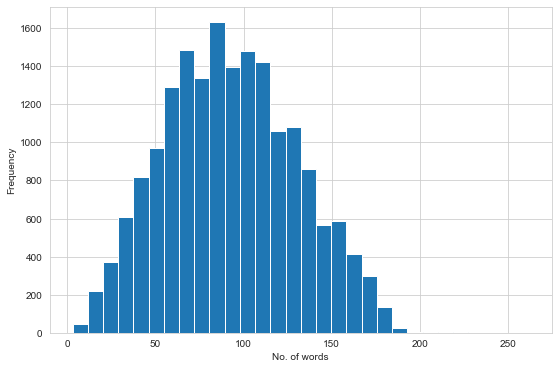

In [22]:
dat['word_count'].plot(kind='hist',bins=30,figsize=(9,6))
plt.xlabel('No. of words')
plt.ylabel('Frequency')
plt.show()

#what are the top 50 most frequent words among all abstracts?
from collections import Counter
words =[]
for abstract in dat['clean_abstract']:
    words=words+abstract.split(' ')
    
word_count_all = Counter(words)
top50 = pd.DataFrame(word_count_all.most_common(50))

# 5. Recommendation engine
  * Convert each abstract into vectors using TF-IDF 
  * Calculate similarity between all abstracts using cosine similarity
  * Define a function that takes abstract as input, and returns the top 5 similar recommended articles based on the abstract

In [23]:
#convert abstract into vectors using TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_count_vec = TfidfVectorizer(analyzer='word', norm='l2')
tfidf_count_occurs = tfidf_count_vec.fit_transform(dat['clean_abstract'])
tfidf_count_occur_df = pd.DataFrame(
    (count, word) for word, count in zip(
    tfidf_count_occurs.toarray().tolist()[0],   
    tfidf_count_vec.get_feature_names()))
tfidf_count_occur_df.columns = ['Word', 'Count']
tfidf_count_occur_df.sort_values('Count', ascending=False, inplace=True)
tfidf_count_occur_df.head()

#calculate cosine_similarity
from sklearn.metrics.pairwise import cosine_similarity
sg = cosine_similarity(tfidf_count_occurs, tfidf_count_occurs)

#define a fuction recommend() to return the top 5 similar articles
def article_recommend(title):
    indices = pd.Series(dat.index,index=dat['title'])
    idx = indices[title]
    sig = list(enumerate(sg[idx]))
    sig = sorted(sig, key=lambda x: x[1], reverse=True)
    sig = sig[1:6]
    paper_indices = [i[0] for i in sig]
    rec = dat[['title']].iloc[paper_indices]
    print('\nHere are the top 5 similar articles that may interest you:')
    print('--------------------------\n')
    for n,i in enumerate(sig):
        print('#{}.'.format(n+1), 'Title: “{}”.'.format(dat['title'][i[0]]),'(DOI:{})\n'.format(dat['doi'][i[0]]))
        

In [24]:
article_recommend('Banach-like metrics and metrics of compact sets')


Here are the top 5 similar articles that may interest you:
--------------------------

#1. Title: “Efficient PDE constrained shape optimization based on Steklov-Poincar\'e
  type metrics”. (DOI:10.1137/15M1029369)

#2. Title: “A Locally Weighted Fixation Density-Based Metric for Assessing the
  Quality of Visual Saliency Predictions”. (DOI:10.1109/TIP.2016.2577498)

#3. Title: “Sparse Geometric Representation Through Local Shape Probing”. (DOI:10.1109/TVCG.2017.2719024)

#4. Title: “Hexagonal geodesic 3-webs”. (DOI:None)

#5. Title: “Common Metrics to Benchmark Human-Machine Teams (HMT): A Review”. (DOI:10.1109/ACCESS.2018.2853560)

